In [6]:
ITERATIONS = 20
import numpy as np
import copy
import pandas as pd

### Print the address of all stores

In [105]:
df = pd.read_json("Stores_List.json")
df = df.drop(columns=['address'])
df_list = df.iloc[:,0]
df

,name
0,凱松
1,經貿
2,馥樺
3,中坡
4,玉德
5,港運
6,向揚
7,新福玉
8,玉成
9,港泰


### Read the Adjacency Matrix

In [8]:
Adjacency_Matrix = pd.read_csv("adjacency_matrix.csv", index_col=0).to_numpy()
Target_Data = Adjacency_Matrix
Adjacency_Matrix

array([[0.  , 4.2 , 4.1 , ..., 2.1 , 2.8 , 1.8 ],
       [5.1 , 0.  , 0.13, ..., 4.2 , 1.5 , 2.7 ],
       [4.9 , 0.13, 0.  , ..., 4.3 , 1.4 , 2.8 ],
       ...,
       [2.1 , 4.3 , 4.4 , ..., 0.  , 3.4 , 1.6 ],
       [2.9 , 1.7 , 1.2 , ..., 3.3 , 0.  , 1.8 ],
       [1.8 , 2.7 , 2.9 , ..., 1.5 , 1.8 , 0.  ]])

#### A Random Generate Initial Schedule

In [9]:
baseline_schedule = list(range(len(Adjacency_Matrix)))
baseline_schedule = np.random.permutation(baseline_schedule)
baseline_schedule

array([29,  0,  7, 21, 27, 23, 19, 15, 33, 16, 13, 25, 24,  3,  8, 34, 35,
        5,  6, 22, 11, 17, 26, 14, 32,  2, 30, 31,  4,  1, 18, 12, 20, 28,
        9, 10])

##### Common methods

In [77]:
def Get_Schedule_Length(given_schedule):
    # Adjust the given_schedule (schedule), for example [A, B, C] -> [A, B, C, A]
    # then compute the travel distance of the given array.
    given_schedule = np.append(given_schedule, given_schedule[0])
    sum = 0
    for j in range(len(given_schedule)-1):
        sum += Target_Data[given_schedule[j],given_schedule[j+1]]
    return sum

def Get_Best_Neighbor(current_schedule):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]
            permutation.append(neighbor)
    permutation = np.asarray(permutation)
    min = np.inf
    for k in range(len(permutation)):
        if (Get_Schedule_Length(permutation[k]) < min):
            min = Get_Schedule_Length(permutation[k])
            schedule_with_shortest_distance = permutation[k]
    return schedule_with_shortest_distance

##### 3(a) Hill Climbing

In [79]:
initial_schedule = baseline_schedule
best_schedule = initial_schedule
best_result = Get_Schedule_Length(initial_schedule)

# add the travel distance of initial schedule to the array which stored the result.
HC = [best_result]

# Start Iterations
for i in range(ITERATIONS):# try 10000 possible route in each iteration. (much less than 15!)
    current_schedule = Get_Best_Neighbor(best_schedule)
    if Get_Schedule_Length(current_schedule)<best_result:
        best_schedule = current_schedule
        best_result = Get_Schedule_Length(current_schedule)
    HC.append(best_result)
# print(HC)
HC_best_schedule = best_schedule

##### 3(b) Random Walk

In [85]:
initial_schedule = baseline_schedule
best_result = Get_Schedule_Length(initial_schedule)

# add the travel distance of initial schedule to the array which stored the result.
RW = [best_result]

for i in range(ITERATIONS):
    # random select an route from the permutation of old schedule
    current_schedule = np.random.permutation(initial_schedule)
    if Get_Schedule_Length(current_schedule)<best_result:
        best_schedule = current_schedule
        best_result = Get_Schedule_Length(current_schedule)
    RW.append(best_result)

# save the schedule with best result of RW.
RW_best_schedule = best_schedule

##### 3(c) Genetic Algorithm - setup

In [13]:
POPULATION_SIZE = 10
CROSSOVER_PROBABILITY = 0.1
NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP = 2

def Generate_Population(initial_schedule):
    Population = []
    for i in range(POPULATION_SIZE):
        Single_Creature = np.random.permutation(initial_schedule)
        Population.append(Single_Creature)
    return Population

def Roulete_Wheel_Selection(Given_Matrix):
    A = []
    max = -np.inf
    for i in range(len(Given_Matrix)):
        schedule_length = Get_Schedule_Length(Given_Matrix[i])
        A.append(schedule_length)
        if schedule_length > max:
            max = schedule_length

    sum = 0
    for j in range(len(Given_Matrix)):
        sum += A[j]
        A[j] = sum

    Matepool = []
    for k in range(int(len(Given_Matrix)/2)):
        a = np.random.randint(sum)
        i=0
        while(a>A[i]):
            i += 1
        Matepool.append(Given_Matrix[i])

    return Matepool

def Uniform_Crossover(Given_Matrix):
    Test_Matrix = Given_Matrix
    for i in range(int(len(Test_Matrix)/2)):

        for j in range(int(len(Test_Matrix[i]))):
            a = np.random.uniform(0,1,1)
            if a >= CROSSOVER_PROBABILITY:
                # SWAP the elements among two weapons lists.
                Test_Matrix[2*i][j], Test_Matrix[2*i+1][j] = Test_Matrix[2*i+1][j], Test_Matrix[2*i][j]
    return Test_Matrix

def Multi_Bit_Flip_Mutation(Given_Matrix, Number_of_Pairs_of_Multi_Bit_Flip):
    Test_Matrix = Given_Matrix
    # Doubling the population size in the step\
    # \to make the amount of creatures fixed in each generations.
    Test_Matrix = np.concatenate((Test_Matrix, Test_Matrix))

    #
    for i in range(int(len(Test_Matrix)/2)):
        for j in range(Number_of_Pairs_of_Multi_Bit_Flip):
            interchange_location = np.random.randint(int(len(Test_Matrix[i])),size=2)
            Test_Matrix[i][interchange_location[0]], Test_Matrix[i][interchange_location[1]] =\
            Test_Matrix[i][interchange_location[1]], Test_Matrix[i][interchange_location[0]]

    return Test_Matrix

def Get_the_Best_Combination(Given_Matrix, print_result):
    min = np.inf
    for i in range(len(Given_Matrix)):
        if Get_Schedule_Length(Given_Matrix[i]) < min:
            min = Get_Schedule_Length(Given_Matrix[i])
            best_combination = Given_Matrix[i]
    if (print_result):
        print(f'   The best combination in the current generation is: {best_combination}'
              f'\n    with schedule travel distance: {min}')
    return min, best_combination

##### 3(c) Genetic Algorithm - main

In [95]:
initial_schedule = baseline_schedule
best_result = Get_Schedule_Length(initial_schedule)

# add the travel distance of initial schedule to the array which stored the result.
GA = [best_result]


Population = Generate_Population(initial_schedule)
for iters in range(int(ITERATIONS/POPULATION_SIZE)):
    Selected_Creatures = Roulete_Wheel_Selection(Population)
    Syngamy = Uniform_Crossover(Selected_Creatures)
    Next_Generation = Multi_Bit_Flip_Mutation(Syngamy,
                                              NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
    Population = Next_Generation
    current_result, current_schedule = Get_the_Best_Combination(Next_Generation,
                                                                print_result=0)

    if Get_Schedule_Length(current_schedule)<best_result:
        best_schedule = current_schedule
        best_result = Get_Schedule_Length(current_schedule)
    # Since GA is a population-wise comparison algorithms,
    # append the best result multiple times to compare GA with other algorithms.
    for population_size in range(POPULATION_SIZE):
        GA.append(best_result)
GA_best_result = GA[-1]
GA_best_result
# save the schedule with best result of RW
GA_best_schedule = best_schedule

##### 3(d) Simulated Annealing - setup

In [15]:
# Hyper parameters
NO_UPDATE_TIMES = 10e4 #10e4
n = 2 # iterations
c = 0.7 # temperature reduction factor

# Generate Initial Temperature
rand_4pts = []
for i in range(4):
    Creature = np.random.permutation(initial_schedule)
    rand_4pts.append(Get_Schedule_Length(Creature))
init_temp = np.average(rand_4pts)

# Generate Initial Schedule
# current_schedule = np.random.permutation(initial_schedule)
SA = []

## Some Initializations
no_update_times = 0
initial_schedule = baseline_schedule
des_schedule = initial_schedule #current_schedule
temp = init_temp    # set the temperature to initial temperature
iters_sum = 0

##### 3(d) Simulated Annealing - main

In [16]:
while no_update_times<=NO_UPDATE_TIMES:

    iter = 0

    while (iter <= n)&(no_update_times <= NO_UPDATE_TIMES):
        # Compute current_state
        current_state = Get_Schedule_Length(des_schedule)

        r = np.random.permutation(des_schedule)
        attempt_state = Get_Schedule_Length(r)

        # Step 3 and Step 4
        del_f = attempt_state - current_state

        if del_f<0:
            #print(f'del_f:{del_f}')
            c = np.random.uniform(0, 1, 1)
            Prob_of_X_2 = np.exp(-del_f/(1*temp))
            #print(f' r = {r} , $P(X_2)$ = {Prob_of_X_2}')
            if Prob_of_X_2 > c:
                des_schedule = r
                #print(f'! assign new design (x) = {des_schedule}')
                SA.append(float(Get_Schedule_Length(r)))
                current_state = attempt_state
                temp = c*temp
                no_update_times = 0
        else:
            no_update_times +=1

        iter += 1
        iters_sum += 1

print(f'   The best combination over all generations is: {des_schedule}')
print(f'\n    with travel distance: {current_state}')
SA_best_schedule = des_schedule

   The best combination over all generations is: [33 16 32 26 12  4 15 13 14  3  7  0  5 34 35  1 10  6  9 17 18 19 27 31
 21 22 11 30 29 24 25 23 20  8  2 28]

    with travel distance: 59.81600000000001


##### 3(e) Tabu Search - setup

In [17]:
# build a boolean table for TS, to determine whether swap or not
size = len(Target_Data)
TS_boolean_table = np.zeros((size, size), dtype=bool)
for i in range(size):
    TS_boolean_table[0, i] = TS_boolean_table[i, 0] = 1

def Get_Permutation(current_schedule):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]

            # to convenient the work, I set the data structure of permutation matrix as follow
            # i, j will memorized which cities were swapped in the current route.
            # example:
            #   0   1   2      3    ...   15       16      17      18
            #   i   j   City1  City2      City14   City15  City1   0 (the place to fill in total travel distance)
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .

            loc = [i, j]    # correspond to boolean table
            loc.extend(neighbor)    # schedule after randomly swapping two cities
            loc.extend([0])   # a place to memorized the city we start and another for total distance
            permutation.append(loc)
    permutation = np.array(permutation)
    return permutation

def Get_New_Schedule(permutation, best_result, boolean_table):
    # declaration
    store_i = 0
    store_j = 0
    current_schedule = []

    # compare all possibilities route in permutation matrix, and choose the best.
    for i in range(len(permutation)):
        sum = Get_Schedule_Length(permutation[i, 2:2+len(Target_Data)])

        if boolean_table[permutation[i,0], permutation[i,1]]!=1:
            permutation[i,2+len(Target_Data)] = int(sum)
            if (sum < best_result):
                best_result = sum
                store_i = permutation[i,0]
                store_j = permutation[i,1]
                current_schedule = permutation[i, 2:2+len(Target_Data)]

    # mark the cities that have been swapped
    boolean_table[store_i, store_j] = 1
    boolean_table[store_j, store_i] = 1

    return current_schedule, best_result, boolean_table

##### 3(e) Tabu Search - main

In [18]:
initial_schedule = baseline_schedule
current_schedule = initial_schedule
best_schedule = current_schedule
best_result = Get_Schedule_Length(initial_schedule)

TS = [best_result]

for i in range(ITERATIONS):
    # print(f'Step:{i}')
    permutation = Get_Permutation(best_schedule)
    current_schedule, best_result, TS_boolean_table = Get_New_Schedule(permutation,
                                                                       best_result,
                                                                       TS_boolean_table)
    if current_schedule != []:
        best_schedule = current_schedule
    else:
        pass

    TS.append(Get_Schedule_Length(best_schedule))

TS_best_schedule = best_schedule

<ipython-input-18-3ce27a4d5d09>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if current_schedule != []:


##### 3(f) Particle Swarm Optimization - method

In [19]:
def Get_Permutation_Ver2(current_schedule, index):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]

            # to convenient the work, I set the data structure of permutation matrix as follow
            # i, j will memorized which cities were swapped in the current route.
            # for example:
            #   0                   1   2      3    ...   35       36      37      38      39
            #   particles' index    i   j      City1      City34    City35  City36  City1   The travel distance of the current schedule
            #   .                   .   .      .    ...   .        .       .       .       .
            #   .                   .   .      .    ...   .        .       .       .       .
            #   .                   .   .      .    ...   .        .       .       .       .

            loc = [index, i, j]    # correspond to boolean table
            loc.extend(neighbor)    # schedule after randomly swapping two cities
            loc.extend([Get_Schedule_Length(neighbor)])   # a place to memorized the city we start and another for total distance
            permutation.append(loc)
    permutation = np.array(permutation)
    return permutation

def Schedules_Initialization(Particles):
    Positions = []
    for i in range(Particles):
        Positions.append(np.random.permutation(initial_schedule))
    return Positions

def Initialize_Velocities(Particles):
    return np.zeros(Particles)

### Get Local Best Position
def Get_Local_Best_Schedule(Schedules, Current_Local_Best_Position):
    for i in range(len(Schedules)):
        if Get_Schedule_Length(Schedules[i]) > Get_Schedule_Length(Current_Local_Best_Position[i]):
            Current_Local_Best_Position[i] = Schedules[i]
    # print(f'===== Get_Local_Best_Schedule =====')
    # print(f'Current_Local_Best_Position : {Current_Local_Best_Position}')
    # for j in range(4):
    #     print(f'Local_Best_Position_Value[{j}] : {f(Local_Best_Position[j])}')
    return Current_Local_Best_Position

def Get_Global_Best_Schedule(Local_Best_Schedules,
                             Local_Best_Positions,
                             Global_Best_Schedule,
                             Global_Best_Position):
    global_best_position = 0
    for index in range(len(Local_Best_Schedules)):
        # print(f'index:{index}, Local_Best_Positions[{index}]={Local_Best_Positions[index]}')
        if Local_Best_Schedules[index][-1] <= Get_Schedule_Length(Global_Best_Schedule):
            Global_Best_Schedule = Local_Best_Schedules[index][3:3+len(Target_Data)]
            print(f'Global_Best_Schedule:{Global_Best_Schedule}')
            Global_Best_Position = Local_Best_Positions[index]
    return Global_Best_Schedule, Global_Best_Position

def Get_Velocities_of_Particles(Particles,
                                Local_Best_Position,
                                Global_Best_Position,
                                Current_Velocities):
    New_Velocities = Initialize_Velocities(Particles)
    w = 1; c_1 = 1; c_2 = 0.4
    r_1 = np.random.uniform(0, 1, 1)
    r_2 = np.random.uniform(0, 1, 1)
    for i in range(Particles):
        New_Velocities[i] = w*Current_Velocities[i]\
                            + c_1*r_1*(Global_Best_Position-Local_Best_Position[i])
        New_Velocities[i] = np.round(float(New_Velocities[i]))
    New_Velocities = New_Velocities.astype(int)
    return New_Velocities

def Get_Overall_Schdules_and_Local_Best_Schedules(Current_Schedules,
                                                  boolean_tables):
    Local_Best_Schedules = []
    for i in range(len(Current_Schedules)):
        Permutation_of_Each = Get_Permutation_Ver2(Current_Schedules[i], index= i)
        Permutation_of_Each = np.array(Permutation_of_Each, dtype=int)

        # print(f'Permutation of Each:\n{Permutation_of_Each}')
        # Search for local best position
        min = np.inf
        min_Schedule = Permutation_of_Each[0]
        for j in range(len(Permutation_of_Each)):
            if Permutation_of_Each[j][-1] < min:
                index_x = Permutation_of_Each[j][1]
                index_y = Permutation_of_Each[j][2]
                if (boolean_tables[i][index_x][index_y]==0):
                    min = Permutation_of_Each[j][-1]
                    min_Schedule = Permutation_of_Each[j]
        Local_Best_Schedules.append(min_Schedule)
        boolean_tables[i][min_Schedule[1]][min_Schedule[2]]=1
        boolean_tables[i][min_Schedule[2]][min_Schedule[1]]=1
        #print(f'boolean_tables:\n{boolean_tables}')
        if i == 0:
            overall_schedules = Permutation_of_Each
        else:
            overall_schedules = np.vstack((overall_schedules, Permutation_of_Each))
    return overall_schedules, Local_Best_Schedules

# Find the index of Local Best Schedules in all schedules sorted by travel distances.
def Find_the_index_of_Local_Best_Schedules(Local_Best_Schedules, overall_schedules):
    Local_Best_Positions = []
    for i in range(len(Local_Best_Schedules)):
        for j in range(len(overall_schedules)):
            comparison = Local_Best_Schedules[i] == overall_schedules[j]
            equal_arrays = comparison.all()
            if equal_arrays:
                Local_Best_Positions.append(j)

    print(f'Local Best Positions:{Local_Best_Positions}')
    return Local_Best_Positions

def Sort_Overall_Schedules(overall_schedules):
    return overall_schedules[np.argsort(np.negative(overall_schedules[:, -1]))]

def Get_New_Schedules(New_Positions, overall_schedules):
    New_Schedules = []
    for i in range(len(New_Positions)):
        New_Schedules.append(overall_schedules[New_Positions[i]][3:3+len(Target_Data)])
    return New_Schedules

##### 3(f) Particle Swarm Optimization - setup

In [20]:
PARTICLES = 4
initial_schedule = baseline_schedule
overall_schedules = []

# build several boolean tables for each particle to conduct Tabular Search.
size = len(Target_Data[0])
boolean_tables = []
for i in range(PARTICLES):
    x = np.zeros((size, size), dtype=bool)
    boolean_tables.append(x)

Current_Schedules = Schedules_Initialization(PARTICLES)
Current_Velocities = Initialize_Velocities(PARTICLES)

# Initialize Local Best Position
Local_Best_Schedule = Current_Schedules
# print(f'Local Best Schedule: \n{Local_Best_Schedule}')

# Initialize Global Best Position
Global_Best_Schedule = Current_Schedules[0]
print(f'Global Best Schedule: \n{Global_Best_Schedule}')
### Arbitrarily set a position as Global Best Position from Current_Schedules

Global_Best_Position = 0

Global Best Schedule: 
[22  5 34  9  3  8  4  1 15 27 33  2 30 35 31 23 21 13 19 10  0 16 17 26
  7 29 28 20 24 14 25 18  6 32 12 11]


##### 3(f) Particle Swarm Optimization - main

In [21]:
best_result = Get_Schedule_Length(initial_schedule)
PSO = [best_result]
PSO_overall_best = best_result #np.inf

for i in range(ITERATIONS):
    print(f'\n====== ITERS:{i} ======')
    # print(f'Current Schedules: \n{Current_Schedules}')
    overall_schedules, Local_Best_Schedules \
        = Get_Overall_Schdules_and_Local_Best_Schedules(Current_Schedules,
                                                        boolean_tables)
    # print(f'shape of overall schedules: {np.array(overall_schedules).shape}')

    # sort all schedules by travel distances.
    overall_schedules = Sort_Overall_Schedules(overall_schedules)
    # print(f'overall schedules after descend sorting:\n{overall_schedules}')

    # print(f'Local Best Schedules:\n{Local_Best_Schedules}')
    Local_Best_Positions = Find_the_index_of_Local_Best_Schedules(Local_Best_Schedules,
                                                                  overall_schedules)
    Global_Best_Schedule, Global_Best_Position \
        = Get_Global_Best_Schedule(Local_Best_Schedules,
                                      Local_Best_Positions,
                                      Global_Best_Schedule,
                                   Global_Best_Position)
    #print(f'Global Best Schedule & Position:\n{Global_Best_Schedule, Global_Best_Position}')

    New_Velocities = Get_Velocities_of_Particles(PARTICLES,
                                                 Local_Best_Positions,
                                                 Global_Best_Position,
                                                 Current_Velocities)
    #print(f'New Velocities: {New_Velocities}')
    def Get_New_Positions(Local_Best_Positions, New_Velocities, overall_schedules):
        New_Positions = Local_Best_Positions
        for i in range(len(Local_Best_Positions)):
            if Local_Best_Positions[i]+New_Velocities[i] > len(overall_schedules):
                New_Positions[i] = len(overall_schedules)
            else:
                New_Positions[i] = Local_Best_Positions[i] + New_Velocities[i]
        return New_Positions
    New_Positions = Get_New_Positions(Local_Best_Positions, New_Velocities, overall_schedules)
    print(f'New Positions: {New_Positions}')
    New_Schedules = Get_New_Schedules(New_Positions, overall_schedules)
    # print(f'New Schedules: \n{New_Schedules}')
    test = []
    for i in range(PARTICLES):
        test.append(Get_Schedule_Length(New_Schedules[0]))
    print(f'Travel Distances of each particles:{test}')

    if np.min(test) < PSO_overall_best:
        PSO.append(np.min(test))
        PSO_overall_best = np.min(test)
    else:
        PSO.append(PSO_overall_best)

    Current_Schedules = New_Schedules

# Select the schedule of first particle as best schedule of PSO.
PSO_best_schedule = Current_Schedules[0]



====== ITERS:0 ======
Local Best Positions:[2428, 2493, 2518, 2519]
Global_Best_Schedule:[22  5 34  9  3  8  4  7 15 27 33  2 30 35 31 23 21 13 19 10  0 16 17 26
  1 29 28 20 24 14 25 18  6 32 12 11]
Global_Best_Schedule:[23  4 21 14 24 26 29 33  9 25  1  2  8 32 22 18 11  0 20 10 19 16 17 27
 31 34  7 28  3  5  6 35 12 15 30 13]
Global_Best_Schedule:[24  9 16 31  6  0 18  4 20 17 23 29 19  1 35 14 21 30 28  8 33 27  2 12
 10 25 13  3 15  5 32 11 34  7 22 26]
Global_Best_Schedule:[35 18  8 32  2 17 20 34 28 19 27  0  6 11 30  7  5 12 13 29 26 16  3 33
 25 24 15 31  1 22 10 23  4 14 21  9]
New Positions: [2471, 2505, 2518, 2519]
Travel Distances of each particles:[86.34, 86.34, 86.34, 86.34]

====== ITERS:1 ======
Local Best Positions:[2504, 2516, 2514, 2519]
Global_Best_Schedule:[24  9 16 31  6  0  5  4 20 17 23 29 19  1 35 14 21 30 28  8 33 27  2 12
 10 25 13  3 15 18 32 11 34  7 22 26]
Global_Best_Schedule:[24  9 16 31  6  0  7  4 20 17 23 29 19  1 35 14 21 30 28  8 33 27  2 12
 10 

##### 3(g) Ant Colony Optimization - methods

In [22]:
# Generate permutation from a single schedule.
def Get_Permutation_Ver3(current_schedule):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]

            # to convenient the work, I set the data structure of permutation matrix as follow
            # i, j will memorized which cities were swapped in the current route.
            # example:
            #   0   1   2      3    ...   15       16      17      18
            #   i   j   City1  City2      City14   City15  City1   0 (the place to fill in total travel distance)
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .

            loc = [i, j]    # correspond to boolean table
            loc.extend(neighbor)    # schedule after randomly swapping two cities
            loc.extend([Get_Schedule_Length(neighbor)])   # a place to memorized the city we start and another for total distance
            permutation.append(loc)
    permutation = np.array(permutation, dtype=int)
    return permutation

def Roulette_Wheel_Selection(schedules_list, pheromone, amount_of_selected_schedule):

    A = []
    max = -np.inf
    for i in range(len(pheromone)):
        x = pheromone[i]
        A.append(x)
        if x > max:
            max = x
    #print(f'A:{A}')
    #print(f'max:{max}')

    sum = 0
    for j in range(len(pheromone)):
        #sum = sum + np.max([1,max-A[j]])
        sum += A[j]
        A[j] = sum
    #print(A)

    index = []
    Matepool = []
    for k in range(amount_of_selected_schedule):
        a = np.random.randint(sum)
        #print(f'a:{a}')
        i=0
        while(a>A[i]):
            i += 1
        index.append(i)
        Matepool.append(list(schedules_list[i]))
    #print(f'Matepool:\n{Matepool}')
    #print(f'shape of Matepool: {np.array(Matepool).shape}')

    return index, np.array(Matepool)

# return the index of the shortest schedule from the several schedules input.
def min_index(list):
    index = []
    min = np.min(list)
    for i in range(len(list)):
        if list[i] == min:
            index.append(i)
    return index, min

# handle the change of pheromone in each iterations.
def update_pheromone(pheromone_array, index_of_minimum, index, delta_tau, pdf):
    # pdf means pheromone decay factor
    pheromone_array *= pdf

    for i in range(len(index_of_minimum)):
        pheromone_array[index[index_of_minimum[i]]] += delta_tau

    return pheromone_array

##### 3(g) Ant Colony Optimization - setup

In [99]:
initial_schedule = baseline_schedule
current_schedule = initial_schedule
best_schedule = current_schedule
best_result = Get_Schedule_Length(best_schedule)

ACO= []
ACO_overall_best = best_result
ACO.append(best_result)
ACO_boolean_table = np.zeros((len(Target_Data), len(Target_Data)), dtype=bool)

##### 3(g) Ant Colony Optimization - main

In [100]:
inner_loop_iters = 10
pheromone = []
for j in range(ITERATIONS):   #int(ITERATIONS/inner_loop_iters)
    #print(f'======    ITERS:{j}    ======')
    #print(f'current_schedule: {current_schedule}')

    # Get permutation from current schedule
    permutation = Get_Permutation_Ver3(current_schedule)
    #print(f'permutation:\n {permutation}')
    #print(f'pheromone: {pheromone}')
    # check whether the pheromone list is empty, which means it has not been initialized.
    if not len(pheromone):
        # if the list is empty, then assign the pheromone of each schedule with default values "1".
        pheromone = np.ones(len(permutation))
        #print(f'Pheromone Initialization: {pheromone}')

    for i in range(inner_loop_iters):
        index, candidate_schedules = Roulette_Wheel_Selection(permutation, pheromone, PARTICLES)
        #print(f'index: {index}\n Schedules selected by Roulette Wheel Selection:\n{candidate_schedules}')
        distance_of_selected_schedules = candidate_schedules[:,-1]
        index_of_minimum, min_value = min_index(distance_of_selected_schedules)
        min = np.min(candidate_schedules[:, -1])

        # Compute the new pheromone array
        xi = 2
        delta_tau = xi * len(index_of_minimum) * min_value / min
        #print(f'delta_tau: {delta_tau}')

        new_pheromone = update_pheromone(pheromone, index_of_minimum, index, delta_tau, pdf=0.5)
        #print(f'new_pheromone: {new_pheromone}')
        pheromone = new_pheromone

    new_schedule = permutation[np.argmax(pheromone)]
    #print(f'new_schedule:{new_schedule}')

    avoid_repetition = copy.deepcopy(pheromone)

    count = 0
    while(ACO_boolean_table[new_schedule[0]][new_schedule[1]]==1):
        avoid_repetition[np.argmax(avoid_repetition)] = -np.inf
        # print(f'avoid_repetition: {avoid_repetition}')
        new_schedule = permutation[np.argmax(avoid_repetition)]
        # print(f'The selected new_schedule is repeated, new new_schedule is: {new_schedule}')
        count += 1
        if count > 20: break

    ACO_boolean_table[new_schedule[0]][new_schedule[1]] = 1
    ACO_boolean_table[new_schedule[1]][new_schedule[0]] = 1

    current_schedule=new_schedule[2:2+len(Target_Data)]
    if(new_schedule[-1]<ACO_overall_best):
        ACO.append(new_schedule[-1])
        ACO_overall_best = new_schedule[-1]
        ACO_best_schedule = current_schedule
    else:
        ACO.append(ACO_overall_best)

---
### 6. Find New Method by Yourself

##### 6-(b) Migrating Birds Optimization, MBO
* reference: https://link.springer.com/chapter/10.1007/978-3-642-20525-5_26

In [25]:
def leading_bird_initialization(schedule, neighborhood_size):
    neighbor_solutions = []
    score_of_neighbor_solutions = []
    for i in range(neighborhood_size):
        rp = np.random.permutation(schedule)
        neighbor_solutions.append(rp)
        score_of_neighbor_solutions.append(Get_Schedule_Length(rp))
    return np.array(neighbor_solutions), np.array(score_of_neighbor_solutions)

def append_random_schedules(initial_schedule, given_schedules, given_scores, k):
    for q in range(k-len(given_schedules)):
        rp = np.random.permutation(initial_schedule)
        given_schedules.append(rp)
        given_scores.append(Get_Schedule_Length(rp))

    return np.array(given_schedules), np.array(given_scores)

##### 6-(b) Migrating Birds Optimization, MBO - setup

In [26]:
# the number of initial solutions
n = 51 # 2*positive_integer + 1, 51
# the number of neighbor solutions to be considered
k = 5
# the number of neighbor solutions to be shared with next solution
x = 1
# number of tours
m = 10

initial_schedule = baseline_schedule
best_result = Get_Schedule_Length(initial_schedule)
best_score_of_each_bird = np.full(n, best_result)
best_schedule_of_each_bird = []
for p in range(n):
    best_schedule_of_each_bird.append(initial_schedule)

##### 6-(b) Migrating Birds Optimization, MBO - main

In [27]:
MBO = []
MBO.append(best_result)
for iterations in range(20):
    for tours in range(m):
        for i in range(n):
            schedules_not_selected = []
            if i == 0:
                score_list = []; leading_bird_schedules = []
                if tours == 0:
                    leading_bird_schedules, score_list = append_random_schedules(initial_schedule, leading_bird_schedules, score_list, k)
                else:
                    leading_bird_schedules.append(best_schedule_of_each_bird[0])
                    score_list.append(best_score_of_each_bird[0])
                    leading_bird_schedules, score_list = append_random_schedules(initial_schedule, leading_bird_schedules, score_list, k)

                x = np.argmin(score_list)
                if score_list[x] < best_score_of_each_bird[i]:
                    best_schedule_of_each_bird[i] = leading_bird_schedules[x]
                    best_score_of_each_bird[i] = score_list[x]

                score_list = np.delete(score_list, x)
                leading_bird_schedules = np.delete(leading_bird_schedules, x, axis=0)

            elif i == 1:
                schedules = []; scores = []
                half = int(len(leading_bird_schedules)/2)
                for j in range(half):
                    schedules.append(leading_bird_schedules[j])
                    scores.append(Get_Schedule_Length(leading_bird_schedules[j]))

                schedules, scores = append_random_schedules(initial_schedule, schedules, scores, k)
                odd_min_index = np.argmin(scores)

                if scores[x] < best_score_of_each_bird[i]:
                    best_schedule_of_each_bird[i] = schedules[odd_min_index]
                    best_score_of_each_bird[i] = scores[odd_min_index]

                odd_schedules = np.delete(schedules, odd_min_index, axis=0)

            elif i == 2:

                schedules = []; scores = []    # print(f'leading_bird_schedules: \n{leading_bird_schedules}')
                for j in range(half+1, k-1):
                    schedules.append(leading_bird_schedules[j])
                    scores.append(Get_Schedule_Length(leading_bird_schedules[j]))
                schedules, scores = append_random_schedules(initial_schedule, schedules, scores, k)

                even_min_index = np.argmin(scores)

                if scores[x] < best_score_of_each_bird[i]:
                    best_schedule_of_each_bird[i] = schedules[even_min_index]
                    best_score_of_each_bird[i] = scores[even_min_index]

                even_schedules = np.delete(schedules, even_min_index, axis=0)

            elif (i > 2) & (i % 2==1 ):
                schedules = []; scores = []
                for j in range(len(odd_schedules)):
                    schedules.append(odd_schedules[j])
                    scores.append(Get_Schedule_Length(odd_schedules[j]))
                schedules, scores = append_random_schedules(initial_schedule, schedules, scores, k)

                odd_min_index = np.argmin(scores)
                # print(odd_min_index)
                if scores[x] < best_score_of_each_bird[i]:
                    best_schedule_of_each_bird[i] = schedules[odd_min_index]
                    best_score_of_each_bird[i] = scores[odd_min_index]

                odd_schedules = np.delete(schedules, odd_min_index, axis=0)

            elif (i > 2) & (i % 2 ==0):
                schedules = []; scores = []
                for j in range(len(even_schedules)):
                    schedules.append(even_schedules[j])
                    scores.append(Get_Schedule_Length(even_schedules[j]))
                schedules, scores = append_random_schedules(initial_schedule, schedules, scores, k)

                even_min_index = np.argmin(scores)
                if scores[x] < best_score_of_each_bird[i]:
                    best_schedule_of_each_bird[i] = schedules[even_min_index]
                    best_score_of_each_bird[i] = scores[even_min_index]
                even_schedules = np.delete(schedules, even_min_index, axis=0)
            else:
                pass
        index_of_best_bird = np.argmin(best_score_of_each_bird)
        temp_score = best_score_of_each_bird[index_of_best_bird]
        temp_schedule = best_schedule_of_each_bird[index_of_best_bird]

        for b in range(index_of_best_bird, 0, -1):
            best_schedule_of_each_bird[b] = best_schedule_of_each_bird[b-1]
            best_score_of_each_bird[b] = best_score_of_each_bird[b-1]

        best_score_of_each_bird[0] = temp_score
        best_schedule_of_each_bird[0] = temp_schedule

        # print(f'best_score_of_each_bird after pulling the best to top of swarm: {best_score_of_each_bird}')
        # print(f'best_schedule_of_each_bird after pulling the best to top of swarm: \n{best_schedule_of_each_bird}')

    MBO.append(best_score_of_each_bird[0])
    MBO_best_schedule = best_schedule_of_each_bird[0]

---
#### FE plot

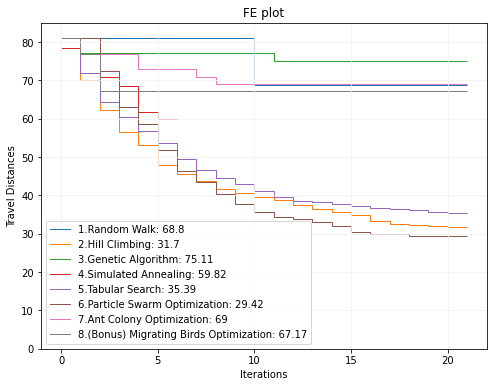

In [101]:
DECIMAL = 2
import matplotlib.pyplot as plt
plot1 = plt.figure(figsize=(8,6))
plot1 = plt.stairs(RW, label=f'1.Random Walk: {np.round_(RW[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(HC, label=f'2.Hill Climbing: {np.round_(HC[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(GA, label=f'3.Genetic Algorithm: {np.round_(GA[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(SA, label=f'4.Simulated Annealing: {np.round_(SA[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(TS, label=f'5.Tabular Search: {np.round_(TS[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(PSO, label=f'6.Particle Swarm Optimization: {np.round_(PSO[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(ACO, label=f'7.Ant Colony Optimization: {np.round_(ACO[-1],DECIMAL)}', baseline=None)
plot1 = plt.stairs(MBO, label=f'8.(Bonus) Migrating Birds Optimization: {np.round_(MBO[-1],DECIMAL)}', baseline=None)

plot1 = plt.xlabel('Iterations')
plot1 = plt.ylabel('Travel Distances')

plot1 = plt.title('FE plot')
# plt.xlim()

plot1 = plt.grid(axis='both', color='0.95')

plot1 = plt.legend(loc=3)

plt.show(plot1)


### 4-b. 繪製路線圖

In [29]:
# 便利商店的經緯度座標
geo_coord = np.array([(25.043153347867666, 121.58364425468034),(25.041103173123904, 121.61312713693661),(25.059037382086778, 121.61525870440428),
             (25.054135538699917, 121.59225228351623),(25.045224145218747, 121.58356789516085),(25.056046383097616, 121.59432076817417),
             (25.038599280843084, 121.6172302909103),(25.054579208833932, 121.6077386970096),(25.050836556515183, 121.59401133933852),
             (25.050348657250424, 121.59465155412765),(25.046477143123493, 121.58770249830508),(25.04778866040208, 121.61614100015376),
             (25.044505947139307, 121.61672871919316),(25.05681262836782, 121.59861266632555),(25.055271630568217, 121.61327731050314),
             (25.050601597971102, 121.58046181604894),(25.053003150477217, 121.60628007187141),(25.053298575131006, 121.60734751235167),
             (25.056649286065145, 121.61848773878559),(25.05655074372385, 121.61573383748998),(25.049074757954397, 121.58171149331223),
             (25.039865311593264, 121.59193683508798),(25.056914138727585, 121.6062759774173),(25.053149114168047, 121.60720915468067),
             (25.052742853642453, 121.60477548906213),(25.03500778797283, 121.61420715789247),(25.049276439127613, 121.58981008666036),
             (25.057273370401063, 121.60135560810153),(25.041868212329888, 121.58810847556839),(25.056769966718267, 121.61300978166763),
             (25.049343957442062, 121.5941502816675),(25.046641462836426, 121.5882561239963),(25.05948581387493, 121.61386015283227),
             (25.053475268988816, 121.58971595098346),(25.052500392976036, 121.61631031050298),(25.059036644156418, 121.61619866817416)])

# 設定地圖中心點
center = [np.mean(geo_coord[:,0]-0.003), np.mean(geo_coord[:,1])]

In [30]:
# 依照自己設定的便利商店順序，對經緯度資料作排序（無關路線圖繪製）
abc = pd.read_json("file.json")
abc['geoloc'] = geo_coord.tolist()
abc = abc.drop(columns=['address'])
sort = pd.merge(df,abc, how='inner', on=['name'])
geo_coord = np.array(sort["geoloc"].to_list())

In [118]:
# output the optimal path
from folium import plugins
import folium
import os
import io
from PIL import Image
map = folium.Map(center, zoom_start=14)
Target_Schedule = PSO_best_schedule
Target_Schedule = np.append(Target_Schedule, Target_Schedule[0])
path = geo_coord[Target_Schedule]

for j in range(len(geo_coord)):
    marker = folium.Marker(location= list(geo_coord[j]),
                           icon=folium.Icon(color='cadetblue'),)
    map.add_child(child=marker)

route = folium.PolyLine(locations = path,
                       weight=3,
                       color='black',
                       opacity=0.7).add_to(map)

# image_data = map._to_png(5)
# # image = Image.open(io.BytesIO(image_data))
# # map.save(os.path.join(r'maps_with_the_routes/ACO.png'))
map

### Print the travel distances and travel path

In [117]:
def print_travel_path(given_list):
    temp = []
    given_list = list(given_list)
    # 將凱松門市設為起點，調整門市index順序
    for j in range(len(given_list)):
        if given_list[0] != 0:
            temp.append(given_list[0])
            given_list.pop(0)
    given_list.extend(temp)
    # print(f'given_list: {given_list}')

    # 列印出門市順序
    for i in range(len(given_list)):
        if i == len(given_list)-1:
            print(f'{df_list[given_list[i]]}', end = '\n\n')
        else:
            print(f'{df_list[given_list[i]]}', end = '->')

print_travel_path(RW_best_schedule)
print_travel_path(HC_best_schedule)
print_travel_path(GA_best_schedule)
print_travel_path(SA_best_schedule)
print_travel_path(TS_best_schedule)
print_travel_path(PSO_best_schedule)
print_travel_path(ACO_best_schedule)
print_travel_path(MBO_best_schedule)

凱松->經貿->耀港->港捷->佳樂->林坊->新福玉->港德->鑫貿->研究->港麗->港運->雄強->聯成->玉成->中貿->昆陽->華技->港勝->重陽->向揚->忠陽->港興->港環球->中研->庄研->胡適->香城->玉德->鵬馳->港泰->慈愛->馥樺->港高鐵->中坡->聯坊

凱松->港運->耀港->中研->胡適->研究->港高鐵->聯坊->港德->新福玉->中坡->玉德->林坊->雄強->忠陽->昆陽->聯成->玉成->向揚->慈愛->港興->佳樂->華技->庄研->港勝->馥樺->中貿->港捷->鑫貿->經貿->香城->港環球->港泰->港麗->重陽->鵬馳

凱松->港運->忠陽->馥樺->港環球->玉成->港捷->港泰->耀港->庄研->華技->雄強->中貿->研究->新福玉->港麗->佳樂->重陽->胡適->林坊->港勝->鑫貿->經貿->香城->港興->聯成->昆陽->中坡->玉德->向揚->鵬馳->聯坊->港高鐵->慈愛->中研->港德

凱松->港運->港興->聯成->經貿->港麗->向揚->港泰->香城->佳樂->港高鐵->慈愛->港捷->耀港->中研->港環球->中貿->鑫貿->庄研->胡適->研究->鵬馳->玉成->馥樺->重陽->港德->林坊->港勝->華技->雄強->玉德->聯坊->昆陽->忠陽->中坡->新福玉

凱松->新福玉->港德->林坊->中研->胡適->香城->鵬馳->玉成->忠陽->昆陽->聯成->向揚->港興->耀港->庄研->華技->研究->港勝->港捷->中貿->馥樺->佳樂->港高鐵->港環球->港麗->港泰->慈愛->重陽->經貿->鑫貿->雄強->聯坊->玉德->中坡->港運

凱松->鵬馳->港德->玉德->中坡->港運->雄強->昆陽->忠陽->聯坊->林坊->新福玉->聯成->華技->庄研->胡適->中研->研究->耀港->港捷->港勝->中貿->港高鐵->港麗->港泰->港環球->佳樂->香城->經貿->馥樺->鑫貿->港興->慈愛->重陽->向揚->玉成

凱松->新福玉->向揚->研究->港高鐵->聯坊->港德->林坊->中坡->胡適->庄研->昆陽->玉成->忠陽->聯成->港運->耀港->中研->港環球->香城->華技->港興->慈愛->馥樺->中貿->港捷->玉德->經貿->佳樂-